<a href="https://colab.research.google.com/github/ptptiwari/CapstoneProjectForrecommendation/blob/main/ReviewSentiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import pandas as pd

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
import pickle, re, requests, json, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import metrics
import csv

nltk.download("stopwords", quiet = True)
nltk.download("wordnet", quiet = True)
nltk.download("punkt", quiet = True)
lemmatizer = WordNetLemmatizer()
english_stopwords = set(nltk.corpus.stopwords.words('english'))

file_path = '/content/gdrive/MyDrive/amazon_review_small.txt'

def read_data():
    # Define a custom dialect to handle quotes and commas
    csv.register_dialect('myDialect', delimiter = ',', quotechar = '"', quoting=csv.QUOTE_ALL, skipinitialspace=True)

    with open(file_path, 'r') as file:
        reader = csv.reader(file, dialect='myDialect')
        data = list(reader)

    # Create DataFrame and assign column names
    df_reviews = pd.DataFrame(data[1:], columns=["star_rating", "review_headline", "review_body"])  # Assuming first row is header

    return df_reviews


df_reviews = read_data()

In [3]:
df_reviews.head()

,star_rating,review_headline,review_body
0,4,Surprisingly delightful,This is a fast read filled with unexpected hum...
1,2,"Works, but not as advertised",I bought one of these chargers..the instructio...
2,2,Oh dear,I was excited to find a book ostensibly about ...
3,2,Incorrect disc!,"I am a big JVC fan, but I do not like this mod..."
4,2,Incorrect Disc,"I love the style of this, but after a couple y..."


In [4]:
df_temp = df_reviews.copy()

In [5]:
print(df_temp.columns)

Index(['star_rating', 'review_headline', 'review_body'], dtype='object')


In [6]:
df_temp

,star_rating,review_headline,review_body
0,4,Surprisingly delightful,This is a fast read filled with unexpected hum...
1,2,"Works, but not as advertised",I bought one of these chargers..the instructio...
2,2,Oh dear,I was excited to find a book ostensibly about ...
3,2,Incorrect disc!,"I am a big JVC fan, but I do not like this mod..."
4,2,Incorrect Disc,"I love the style of this, but after a couple y..."
...,...,...,...
649994,5,Pretty Cool!,We got it for our mom's birthday. She LOVES it...
649995,5,great cd,"this cd is very good. i especially love ""cats ..."
649996,2,An interesting look into Boston's comedy clubs,This was a good documentary on the history of ...
649997,5,Du vol...pour les cowboys!,Avez-vous déjà vu un CD double et un DVD avec ...


In [7]:
df_temp.isnull().sum()

,0
star_rating,0
review_headline,0
review_body,0


In [8]:
df_temp[df_temp.duplicated()].count()

,0
star_rating,0
review_headline,0
review_body,0


In [9]:
# Performing the following preprocessing tasks:

#    1. Remove all html tags.
#    2. Clean punctuations and special characters.
#    3. Apply lower casing.
#    4. Tokenize the content, then apply stemming or lemmatization to each token.
#    5. Remove English stopwords.

def preprocess(review):
    text = re.sub('<.*?>', '', review.lower().strip())
    text = re.sub('[^\w\s]', ' ', text)

    result = ''
    tokens = nltk.word_tokenize(text)
    for t in tokens:
        lemma = lemmatizer.lemmatize(t)
        if lemma not in english_stopwords:
            result += lemma + ' '

    return result


df_clean = df_temp.copy()
df_clean['review_body'] = df_clean['review_body'].apply(lambda x : preprocess(x))

In [10]:
df_clean.columns

Index(['star_rating', 'review_headline', 'review_body'], dtype='object')

<Axes: xlabel='star_rating'>

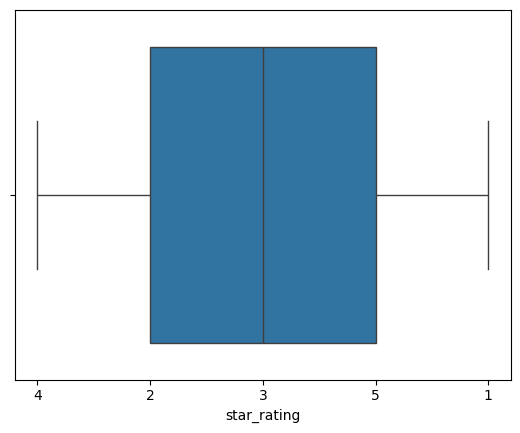

In [11]:
sns.boxplot(x = df_clean['star_rating'])

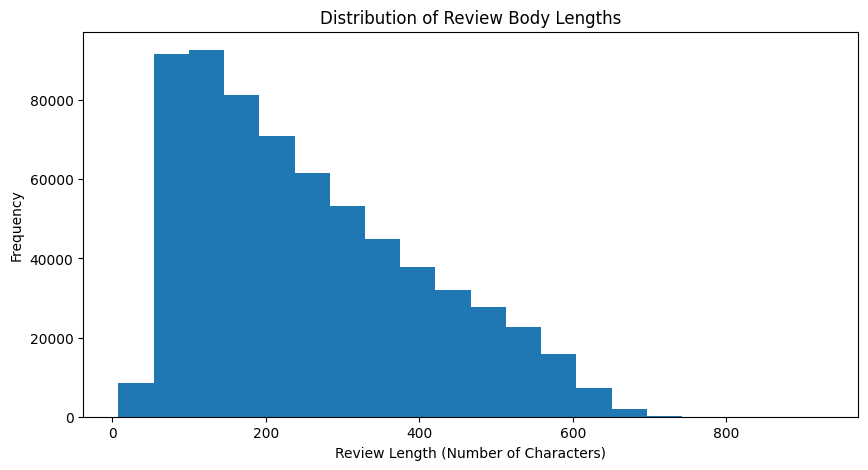

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(df_clean['review_body'].str.len(), bins=20) # Removed extra space at the beginning of this line
plt.xlabel('Review Length (Number of Characters)')
plt.ylabel('Frequency')
plt.title('Distribution of Review Body Lengths')
plt.show()

In [13]:
# Calculate correlations only on numerical columns
numerical_df = df_clean.select_dtypes(include=['number'])
correlation_matrix = numerical_df.corr()
print(correlation_matrix)

Empty DataFrame
Columns: []
Index: []


In [14]:
## FEATURE CONSTRUCTION CODE HERE ##
X = df_clean['review_body']
y = df_clean['star_rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)

In [15]:
cv = CountVectorizer()
X_data = cv.fit_transform(X_train)

In [20]:
## MODEL TRAINING CODE HERE ##
log_reg = LogisticRegression(solver = 'newton-cg')
log_reg.fit(X_data, y_train)

LogisticRegression(solver='newton-cg')

In [21]:
X_data_cv = cv.transform(X_test)
y_pred = log_reg.predict(X_data_cv)

In [22]:
metrics.accuracy_score(y_test.values, y_pred)

0.4640410256410256

In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer # Import CountVectorizer

# Vectorize text data
cv = CountVectorizer()
X_train_vec = cv.fit_transform(X_train) # Vectorize X_train
X_test_vec = cv.transform(X_test) # Vectorize X_test

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_vec.toarray()) # Scale vectorized data, convert to array
X_test_scaled = scaler.transform(X_test_vec.toarray()) # Scale vectorized data, convert to array

# Hyperparameter tuning
param_grid = {'C': [0.01, 0.1, 1, 10], 'solver': ['newton-cg', 'lbfgs']}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train) # Fit on scaled data

# Best model
best_log_reg = grid_search.best_estimator_

# Predictions
y_pred = best_log_reg.predict(X_test_scaled) # Predict on scaled data

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

NameError: name 'X_train' is not defined

In [41]:
# Initialize CountVectorizer (you can customize parameters)
vectorizer = CountVectorizer()

# Fit the vectorizer on your training data (learn vocabulary)
X_train_vec = vectorizer.fit_transform(X_train)

# Transform your test data using the same vocabulary
X_test_vec = vectorizer.transform(X_test)

In [42]:
from sklearn.preprocessing import StandardScaler

# Optimized CountVectorizer
vectorizer = CountVectorizer(max_features=3000, stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Scaling (using MaxAbsScaler for sparse matrices)
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_vec)
X_test_scaled = scaler.transform(X_test_vec)


In [47]:
from sklearn.model_selection import train_test_split, GridSearchCV

# Model Training and Hyperparameter Tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga']  # Choose solvers that work well with sparse data
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [61]:
# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
accuracy = best_model.score(X_test_scaled, y_test)
print("Test Accuracy of Best Model:", accuracy)

Best Hyperparameters: {'C': 1, 'solver': 'saga'}
Test Accuracy of Best Model: 0.46975384615384613


In [71]:
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping
# Assuming y_train contains string labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Similarly, encode y_test
y_test_encoded = label_encoder.transform(y_test)
# --- Keras Neural Network ---
model = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),  # Input layer
    layers.Dense(64, activation='relu'),  # First hidden layer
    layers.Dense(32, activation='relu'),  # Second hidden layer
    layers.Dense(1, activation='sigmoid')  # Output layer (adjust activation if needed) - Change the activation
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Adjust loss if needed
              metrics=['accuracy'])  #  change the loss to mean squared error
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Now use y_train_encoded and y_test_encoded when training and evaluating your model
model.fit(X_train_scaled, y_train_encoded, epochs=50, batch_size=32,
          validation_split=0.1, callbacks=[early_stopping])
_, keras_accuracy = model.evaluate(X_test_scaled, y_test_encoded)
print("Test Accuracy (Keras Neural Network):", keras_accuracy)

Epoch 1/50
15540/15540 ━━━━━━━━━━━━━━━━━━━━ 110s 7ms/step - accuracy: 0.2002 - loss: -1481902.1250 - val_accuracy: 0.2004 - val_loss: -17931856.0000
Epoch 2/50
15540/15540 ━━━━━━━━━━━━━━━━━━━━ 147s 7ms/step - accuracy: 0.2004 - loss: -33896348.0000 - val_accuracy: 0.2004 - val_loss: -108183016.0000
Epoch 3/50
15540/15540 ━━━━━━━━━━━━━━━━━━━━ 118s 8ms/step - accuracy: 0.1999 - loss: -150995440.0000 - val_accuracy: 0.2004 - val_loss: -321668960.0000
Epoch 4/50
15540/15540 ━━━━━━━━━━━━━━━━━━━━ 139s 7ms/step - accuracy: 0.2008 - loss: -404326912.0000 - val_accuracy: 0.2004 - val_loss: -708214208.0000
Epoch 5/50
15540/15540 ━━━━━━━━━━━━━━━━━━━━ 139s 7ms/step - accuracy: 0.2004 - loss: -841578432.0000 - val_accuracy: 0.2004 - val_loss: -1316464768.0000
Epoch 6/50
15540/15540 ━━━━━━━━━━━━━━━━━━━━ 139s 7ms/step - accuracy: 0.2001 - loss: -1516894336.0000 - val_accuracy: 0.2004 - val_loss: -2195302144.0000
Epoch 7/50
15540/15540 ━━━━━━━━━━━━━━━━━━━━ 141s 7ms/step - accuracy: 0.2005 - loss: -247

KeyboardInterrupt: 

In [74]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

def create_model(optimizer='adam', neurons=32):
    model = keras.Sequential([
          layers.Input(shape=(X_train_scaled.shape[1],)),  # Input layer
    layers.Dense(64, activation='relu'),  # First hidden layer
    layers.Dense(32, activation='relu'),  # Second hidden layer
    layers.Dense(1, activation='sigmoid')  # Output layer (adjust activation if needed)
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model)
param_grid = {
    'batch_size': [16, 32, 64],
    'epochs': [10, 20, 30],
    'optimizer': ['adam', 'rmsprop'],
    'neurons': [16, 32, 64]
}
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train_scaled, y_train_encoded)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

ModuleNotFoundError: No module named 'tensorflow.keras.wrappers'

In [15]:
# --- TF-IDF Vectorization ---
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=3000, stop_words='english', ngram_range=(1,2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [17]:
# --- Scaling (Optional for SVM) ---
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_vec)
X_test_scaled = scaler.transform(X_test_vec)

In [27]:
# --- SVM Model with Hyperparameter Tuning ---
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC

param_grid = {'C': [0.1, 1, 10]}  # Adjust the range as needed
grid_search = GridSearchCV(LinearSVC(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: Futu

In [28]:
# --- Evaluation ---
y_pred = best_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)
print("Best Hyperparameters:", grid_search.best_params_)

Test Accuracy: 0.46905641025641026
Best Hyperparameters: {'C': 0.1}


In [80]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [81]:
# TF-IDF Vectorization with Character N-grams
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,3), analyzer='char')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:547: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


In [18]:
from xgboost import XGBClassifier

# Assuming y_train contains labels starting from 1, adjust if needed
y_train = y_train.astype(int) - 1

# Initialize XGBoost model with hyperparameters
model = XGBClassifier(n_estimators=100, learning_rate=0.1)

# Fit the model to the training data
model.fit(X_train_vec, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [22]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test_vec)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.0


In [23]:


# Check labels (again)
print("Unique values in y_train (after adjustment):", np.unique(y_train))

# Inspect vocabulary
feature_names = vectorizer.get_feature_names_out()
print("First 20 features:", feature_names[:20])

# Check training accuracy
y_train_pred = model.predict(X_train_vec)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

Unique values in y_train (after adjustment): [0 1 2 3 4]
First 20 features: ['00' '000' '10' '10 minute' '10 year' '100' '11' '12' '13' '14' '15'
 '15 minute' '16' '17' '18' '19' '1st' '20' '20 minute' '20 year']
Training Accuracy: 0.43417454149238277


In [24]:

# TF-IDF Vectorization (with increased max_features and word n-grams)
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english', ngram_range=(1,2), analyzer='word')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# XGBoost Model (with adjusted hyperparameters)
model = XGBClassifier(n_estimators=200, learning_rate=0.05)
model.fit(X_train_vec, y_train)

# Evaluation
y_pred = model.predict(X_test_vec)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.0


In [28]:
# Tiny Dataset (replacing with our actual data loading)
X_tiny = X[:1000]
y_tiny = y[:1000]

# Basic TF-IDF
vectorizer = TfidfVectorizer()
X_tiny_vec = vectorizer.fit_transform(X_tiny)

# Simple Logistic Regression
model = LogisticRegression()
model.fit(X_tiny_vec, y_tiny)

# Prediction and Evaluation
y_pred_tiny = model.predict(X_tiny_vec)
accuracy_tiny = accuracy_score(y_tiny, y_pred_tiny)
print("Tiny Dataset Accuracy:", accuracy_tiny)

# Printing everything
print("Tiny Dataset (X):", X_tiny)
print("Tiny Dataset Labels (y):", y_tiny)
print("TF-IDF Vectors:", X_tiny_vec.toarray()) # Convert to dense for easy viewing
print("Predicted Labels:", y_pred_tiny)

Tiny Dataset Accuracy: 0.983
Tiny Dataset (X): 0      fast read filled unexpected humour profound in...
1      bought one charger instruction say light stay ...
2      wa excited find book ostensibly muslim feminis...
3      big jvc fan like model wa suspiscious saw seve...
4      love style couple year dvd giving problem even...
                             ...                        
995    worth italian actor raoul bova give life marce...
996    one biggest disappointment seen time main comp...
997    best great scenery good looking men typically ...
998    ok story may little slow unrealistic actually ...
999    tuscan sun sound like dish macaroni grill movi...
Name: review_body, Length: 1000, dtype: object
Tiny Dataset Labels (y): 0      4
1      2
2      2
3      2
4      2
      ..
995    3
996    2
997    2
998    5
999    2
Name: star_rating, Length: 1000, dtype: object
TF-IDF Vectors: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. .